# Setup #

In [1]:
import os
import glob
import PIL
import random
import torch
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

/home/rz95/miniconda3/envs/ee/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-06 16:00:39.276706: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-06 16:00:39.326976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 16:00:40.301251: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [2]:
DEVICE = torch.device("cpu")
print(DEVICE)

cpu


# Data Loading #

Tuning:
1. Imitate model architecture of existing networks e.g. VGG, ResNet
2. Data Augmentation for monet images

In [3]:
MONET_IMAGES = tf.io.gfile.glob("./monet_jpg/*.jpg")
MONET_2_IMAGES = tf.io.gfile.glob("./monet_berkeley/*.jpg")
PHOTO_IMAGES = tf.io.gfile.glob("./photo_jpg/*.jpg")

In [4]:
MONET_MORE_IMAGES = MONET_IMAGES+MONET_2_IMAGES

In [5]:
# Normalize all the values to be between -1 and 1
def decode_image(images):
    decoded_images = []
    for image in images:
        image = np.asarray(Image.open(image)).astype("float32")
        image = tf.convert_to_tensor(image) # numpy -> tensor
        shape = image.shape
        image = tf.cast(image, tf.float32) / 127.5 - 1
        image = tf.reshape(image, shape)
        decoded_images.append(image)
    return decoded_images

In [6]:
monet_decoded = decode_image(MONET_MORE_IMAGES)
photo_decoded = decode_image(PHOTO_IMAGES)
# need to specify batch size for training subsequent models
monet_ds = tf.data.Dataset.from_tensor_slices(monet_decoded).batch(1) # list -> dataset
photo_ds = tf.data.Dataset.from_tensor_slices(photo_decoded).batch(1)

2023-05-06 16:00:44.483033: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
print("Monet files:", len(monet_ds))
print("Photo files: ", len(photo_ds))

Monet files: 1493
Photo files:  7038


In [8]:
monet_example = next(iter(monet_ds))
photo_example = next(iter(photo_ds))

2023-05-06 16:01:00.287325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1493,256,256,3]
	 [[{{node Placeholder/_0}}]]
2023-05-06 16:01:04.491519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [7038,256,256,3]
	 [[{{node Placeholder/_0}}]]


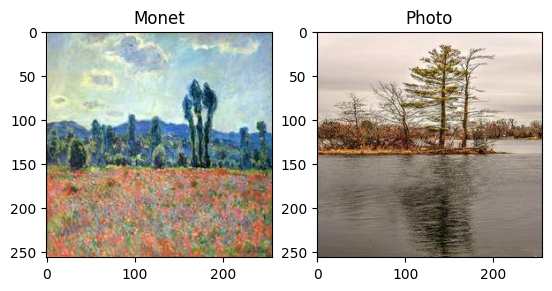

In [9]:
plt.subplot(1,2,1)
plt.title("Monet")
plt.imshow((monet_example[0]+1)/2)

plt.subplot(1,2,2)
plt.title("Photo")
plt.imshow((photo_example[0]+1)/2)

# Data Augmentation #

In [10]:
def data_augmentations():
    model = keras.Sequential()    
    rotation = random.random()
    if rotation<0.3:
        model.add(layers.RandomRotation(factor=(0.5,0.5)))
    elif rotation<0.6:
        model.add(layers.RandomRotation(factor=(1,1)))
    else:
        model.add(layers.RandomRotation(factor=(-0.5,-0.5)))
    flip = random.random()
    if flip<0.3:
        model.add(layers.RandomFlip(mode="horizontal"))
    elif flip<0.6:
        model.add(layers.RandomFlip(mode="vertical"))
    else:
        model.add(layers.RandomFlip(mode="horizontal_and_vertical"))
    model.add(layers.RandomCrop(224, 224, 3))
    model.add(layers.Resizing(256, 256))
    return model

In [11]:
augmented = []
for monet in monet_ds:
    augmented.append(data_augmentations()(monet))
aug_monet_ds = tf.data.Dataset.from_tensor_slices(augmented).unbatch().batch(1)
aug_monet_ds

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [12]:
print(len(augmented))

1493


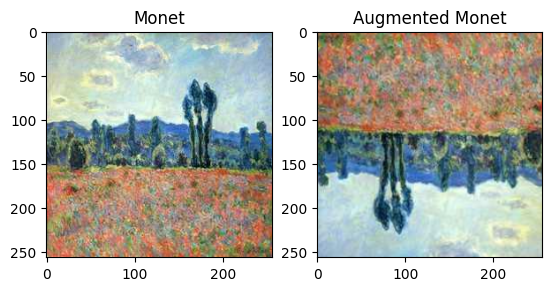

In [13]:
plt.subplot(1,2,1)
plt.title("Monet")
plt.imshow((monet_example[0]+1)/2)

plt.subplot(1,2,2)
plt.title("Augmented Monet")
plt.imshow((data_augmentations()(monet_example)[0]+1)/2)

# Generator #

Our generator is based on a U-Net architecture. A U-Net has a contracting path is composed of a series of convolutional and pooling layers that reduce the spatial dimensionality of the input image while increasing its depth. This helps in extracting high-level features and capturing context from the input image. A U-Net also has an expansive path is composed of a series of upsampling and concatenation operations, followed by convolutional layers that gradually increase the spatial dimensionality of the output. This helps in preserving the localization information and generating high-resolution segmentation maps.

Tuning:
1. Value of dropout, a number between 0.2 and 0.5
2. Dropout applying to more layers, or both contractive and expansive paths 
3. Addition of max / average pooling layers and upsampling as in https://arxiv.org/pdf/1505.04597.pdf

In [14]:
def downsample(num_filter, kernel_size, strides=2, instance_norm=False):
    initializer = keras.initializers.GlorotUniform
    model = keras.Sequential()
    model.add(layers.Conv2D(num_filter, kernel_size, strides=strides, padding="same"))
    # Usually applied to style transfer, as the network needs to learn to represent the style or appearance of the input image, 
    # and the global statistics provided by batch normalization may not be appropriate. 
    # Normalization in general imporves training stability and more efficient backpropogation.
    if instance_norm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=initializer))
    # Prevents dying neuron and 0 gradient, allowing a small output for negative input values
    model.add(layers.LeakyReLU()) 
    return model

In [15]:
def upsample(num_filter, kernel_size, strides=2, instance_norm=False, apply_dropout=False):
    initializer = keras.initializers.GlorotUniform
    model = keras.Sequential()
    model.add(layers.Conv2DTranspose(num_filter, kernel_size, strides=strides, padding="same"))
    if instance_norm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=initializer))
    # prevents overfitting and improves generalization
    if apply_dropout:
        model.add(layers.Dropout(0.2))
    model.add(layers.ReLU()) 
    return model

In [16]:
# def generator():
    
#     # more complex data requires more number of kernels
#     down_stack = [
#         # instance normalization might interfere with learning of low-level features in the first layer
#         downsample(64, 4), # (128, 128, 64)
#         downsample(128, 4, instance_norm=True), # (64, 64, 128)
#         downsample(256, 4, instance_norm=True), # (32, 32, 256)
#         downsample(512, 4, instance_norm=True), # (16, 16, 512)
#         downsample(512, 4, instance_norm=True), # (8, 8, 512)
#         downsample(512, 4, instance_norm=True), # (4, 4, 512)
#         downsample(512, 4, instance_norm=True), # (2, 2, 512)
#         downsample(512, 4, instance_norm=True) # (1, 1, 512)
#     ]
    
#     up_stack = [
#         upsample(512, 4, instance_norm=True, apply_dropout=True), # (2, 2, 512)
#         upsample(512, 4, instance_norm=True, apply_dropout=True), # (4, 4, 512)
#         upsample(512, 4, instance_norm=True, apply_dropout=True), # (8, 8, 512)
#         upsample(512, 4, instance_norm=True), # (16, 16, 512)
#         upsample(256, 4, instance_norm=True), # (32, 32, 256)
#         upsample(128, 4, instance_norm=True), # (64, 64, 128)
#         upsample(64, 4, instance_norm=True), # (128, 128, 64)
#     ]
    
#     # Using tanh to get output between -1 and 1, improves stability and convergence of training in GAN
#     last = layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="tanh")
    
#     inputs = layers.Input(shape=[256,256,3])
#     x = inputs
    
#     # Skip connections address the degradation problem (overfitting and vanishing / exploding gradients with deep neural nets),
#     # ensures feature reusability
#     skips = []
#     for down in down_stack:
#         x = down(x)
#         skips.append(x)
        
#     skips = reversed(skips[:-1])
    
#     for skip, up in zip(skips, up_stack):
#         x = up(x)
#         x = layers.Concatenate()([skip, x]) 

#     x = last(x)
    
#     return keras.Model(inputs=inputs, outputs=x)

In [17]:
# # vgg inspired
# def generator():
#     # more complex data requires more number of kernels
#     down_stack = [
#         # instance normalization might interfere with learning of low-level features in the earlier layer
#         downsample(16, 3, strides=1), # (256, 256, 16)
#         downsample(16, 3, strides=1, instance_norm=True), # (256, 256, 16)
#         layers.MaxPool2D(), # (128, 128, 16)
#         downsample(32, 3, strides=1, instance_norm=True), # (128, 128, 32)
#         downsample(32, 3, strides=1, instance_norm=True), # (128, 128, 32)
#         layers.MaxPool2D(), # (64, 64, 32)
#         downsample(64, 3, strides=1, instance_norm=True), # (64, 64, 64)
#         downsample(64, 3, strides=1, instance_norm=True), # (64, 64, 64)
#         layers.MaxPool2D(), # (32, 32, 64)
#         downsample(128, 3, strides=1, instance_norm=True), # (32, 32, 128)
#         downsample(128, 3, strides=1, instance_norm=True) # (32, 32, 128)
#     ]
    
#     up_stack = [
#         upsample(128, 3, instance_norm=True, apply_dropout=True), # (64, 64, 128)
#         downsample(64, 3, strides=1, instance_norm=True), # (64, 64, 64)
#         downsample(64, 3, strides=1, instance_norm=True), # (64, 64, 64)
#         upsample(64, 3, instance_norm=True), # (128, 128, 64)
#         downsample(64, 3, strides=1, instance_norm=True), # (128, 128, 64)
#         downsample(64, 3, strides=1, instance_norm=True), # (128, 128, 64)
#         upsample(48, 3, instance_norm=True), # (256, 256, 48)
#         downsample(64, 3, strides=1, instance_norm=True), #(256, 256, 64)
#         downsample(64, 3, strides=1, instance_norm=True) #(256, 256, 64)
#     ]
    
#     inputs = layers.Input(shape=[256,256,3])
#     x = inputs
    
#     # Skip connections address the degradation problem (overfitting and vanishing / exploding gradients with deep neural nets),
#     # ensures feature reusability
#     skips = []
#     for i, down in enumerate(down_stack):
#         x = down(x)
#         if i==1 or i==4 or i==7:
#             skips.append(x)
        
#     skips = list(reversed(skips))
    
#     for j, up in enumerate(up_stack):
#         x = up(x)
#         if j==0 or j==3 or j==6:
#             x = layers.Concatenate()([skips[j//3], x]) 

#     last = layers.Conv2D(3, 1, strides=1, padding="same")
#     x = last(x)
    
#     return keras.Model(inputs=inputs, outputs=x)

In [18]:
# increase depth of model
# multiple kinds of abstractions for feature maps instead of very high-level abstractions
def generator():
    # more complex data requires more number of kernels
    down_stack = [
        # instance normalization might interfere with learning of low-level features in the first layer
        downsample(64, 3, strides=1), # (256, 256, 64)
        downsample(128, 3, instance_norm=True), # (128, 128, 128)
        downsample(256, 3, instance_norm=True), # (64, 64, 256)
        downsample(256, 3, strides=1, instance_norm=True), # (64, 64, 256)
        downsample(256, 3, strides=1, instance_norm=True), # (64, 64, 256)
        downsample(256, 3, strides=1, instance_norm=True), # (64, 64, 256)
        downsample(256, 3, strides=1, instance_norm=True), # (64, 64, 256)
        downsample(256, 3, strides=1, instance_norm=True) # (64, 64, 256)
    ]
    
    up_stack = [
        upsample(128, 3, instance_norm=True, apply_dropout=True), # (128, 128, 128)
        upsample(64, 3, instance_norm=True) # (256, 256, 64)
    ]
    
    # Using tanh to get output between -1 and 1, improves stability and convergence of training in GAN
    last = layers.Conv2DTranspose(3, 3, strides=1, padding="same", activation="tanh") # (256, 256, 3)
    
    inputs = layers.Input(shape=[256,256,3])
    x = inputs
    
    # Skip connections address the degradation problem (overfitting and vanishing / exploding gradients with deep neural nets),
    # ensures feature reusability
    skips = []
    for i, down in enumerate(down_stack):
        x = down(x)
        if i==0 or i==1:
            skips.append(x)
        
    skips = list(reversed(skips))
    
    for skip, up in zip(skips, up_stack):
        x = up(x)
        x = layers.Concatenate()([skip, x]) 

    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

# Discriminator #

The discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

Tuning: 
1. Value for / add dropout
2. Whether output a smaller image or a single 0 or 1 value

In [19]:
def discriminator():
    initializer = keras.initializers.GlorotUniform
    input = layers.Input(shape=[256, 256, 3]) 
    x = input
    x = downsample(64, 4)(x) # (128, 128, 64)
    x = downsample(128, 4, instance_norm=True)(x) # (64, 64, 128)
    x = downsample(256, 4, instance_norm=True)(x) # (32, 32, 256)
    # zero padding prevents the border information from being lost
    x = layers.ZeroPadding2D()(x) # (34, 34, 256)
    # output size = (input size - kernel size)/stride + 1
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer)(x) # (31, 31, 512)
    x = tfa.layers.InstanceNormalization(gamma_initializer=initializer)(x)
    # activation usually happens after normalization
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x) # (32, 32, 512)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x) # (30, 30, 1)
    return keras.Model(inputs=input, outputs=x)

# Model Initialization #

In [20]:
monet_generator = generator()
photo_generator = generator()
monet_discriminator = discriminator()
photo_discriminator = discriminator()

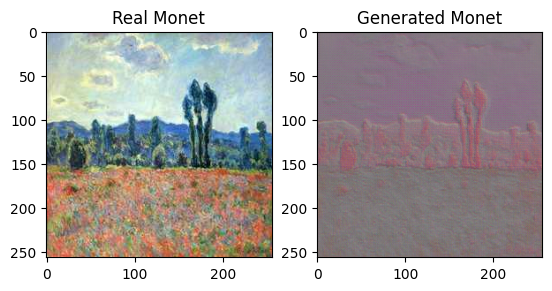

In [21]:
generated_monet_example = monet_generator(monet_example)

plt.subplot(1,2,1)
plt.title("Real Monet")
plt.imshow((monet_example[0]+1)/2)

plt.subplot(1,2,2)
plt.title("Generated Monet")
plt.imshow((generated_monet_example[0]+1)/2)

# CycleGAN Model #

Tuning:
1. Value of LAMBDA, a number between 5 and 10
2. Wasserstein Loss instead of binary cross entropy loss 

In [22]:
class CycleGAN(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10, 
        **kwargs
    ):
        # override model class methods
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lbd = lambda_cycle
        
    def compile(
        self, 
        monet_generator_optimizer,
        photo_generator_optimizer,
        monet_discriminator_optimzer,
        monet_discriminator_optimizer, 
        generator_loss, 
        discriminator_loss, 
        cycle_gan_loss,
        identity_loss
    ):
        super(CycleGAN, self).compile()
        self.m_gen_opt = monet_generator_optimizer
        self.p_gen_opt = photo_generator_optimizer
        self.m_disc_opt = monet_discriminator_optimzer
        self.p_disc_opt = monet_discriminator_optimizer
        self.gen_loss = generator_loss
        self.disc_loss = discriminator_loss
        self.c_gan_loss = cycle_gan_loss
        self.id_loss = identity_loss
        
    def train_step(self, batch): 
        real_monet, real_photo = batch
        
        # persistent=True allows multiple calls to gradient
        with tf.GradientTape(persistent=True) as tape:
            # monet to photo to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycle_monet = self.m_gen(fake_photo, training=True)
            
            # photo to monet to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycle_photo = self.p_gen(fake_monet, training=True)
            
            # generate self
            self_monet = self.m_gen(real_monet, training=True)
            self_photo = self.p_gen(real_photo, training=True)
            
            # discrminator output
            real_monet_disc = self.m_disc(real_monet, training=True)
            fake_monet_disc = self.m_disc(fake_monet, training=True)
            real_photo_disc = self.p_disc(real_photo, training=True)
            fake_photo_disc = self.p_disc(fake_photo, training=True)
            
            # generator loss
            monet_gen_loss = self.gen_loss(fake_monet)
            photo_gen_loss = self.gen_loss(fake_photo)
            
            # cycle loss
            cycle_gan_loss = self.c_gan_loss(real_monet, cycle_monet, self.lbd)+self.c_gan_loss(real_photo, cycle_photo, self.lbd)
            
            # total generator loss
            total_monet_gen_loss = monet_gen_loss + cycle_gan_loss + self.id_loss(real_monet, self_monet, self.lbd)
            total_photo_gen_loss = photo_gen_loss + cycle_gan_loss + self.id_loss(real_photo, self_photo, self.lbd)

            # discriminator loss
            monet_disc_loss = self.disc_loss(real_monet_disc, fake_monet_disc)
            photo_disc_loss =  self.disc_loss(real_photo_disc, fake_photo_disc)
        
        # calculate gradients
        monet_gen_grad = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_gen_grad = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_disc_grad = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_disc_grad = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # apply gradients
        self.m_gen_opt.apply_gradients(zip(monet_gen_grad, self.m_gen.trainable_variables))
        self.p_gen_opt.apply_gradients(zip(photo_gen_grad, self.p_gen.trainable_variables))
        self.m_disc_opt.apply_gradients(zip(monet_disc_grad, self.m_disc.trainable_variables))
        self.p_disc_opt.apply_gradients(zip(photo_disc_grad, self.p_disc.trainable_variables))
        
        return {
            "monet generator loss": total_monet_gen_loss,
            "photo generator loss": total_photo_gen_loss,
            "monet discriminator loss": monet_disc_loss,
            "photo discriminator loss": photo_disc_loss
        }
    
    def call(self):
        super(CycleGAN, self).call()
    
    def get_config(self):
        config = super(CycleGAN, self).get_config()
        config.update({
            "m_gen": self.m_gen, 
            "p_gen": self.p_gen,
            "m_disc": self.m_disc,
            "p_disc":self.p_disc,
            "lbd": self.lbd
        })
        return config
        

In [23]:
# a perfect discrminator outputs an image filled with 1s for a real image and an image filled with 0s for a fake one.
def discriminator_loss(real, fake):
    # "None" returns the loss for each individual sample
    bce = keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.NONE)
    real_disc_loss = bce(tf.ones_like(real), real)
    fake_disc_loss = bce(tf.zeros_like(fake), fake)
    return (real_disc_loss+fake_disc_loss)/2

In [24]:
# the generator wants to fool the discriminator, therefore it wants the output to always be 1s
def generator_loss(fake):
    bce = keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.NONE)
    return bce(tf.ones_like(fake), fake)

In [25]:
# we want the original and the cycled image to be similar to each other
def cycle_gan_loss(real, cycle, LAMBDA):
    # there is technically no target, so use mean
    return LAMBDA*tf.reduce_mean(tf.abs(real-cycle))

In [26]:
# we want the generation of the same image to be as similar as the original image
def identity_loss(real, self, LAMBDA):
    return LAMBDA*0.5*tf.reduce_mean(tf.abs(real-self))

# Training #

Tuning:

1. Learning rate of optimizers
2. Exponential decay rate of 1st moment estimate (average of gradients)
3. Number of epochs

In [27]:
monet_generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5) 
photo_generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5) 
monet_discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5) 
photo_discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5) 

In [28]:
gan = CycleGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
gan.compile(monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer,
            generator_loss, discriminator_loss, cycle_gan_loss, identity_loss)
# this step makes batch operation easier
# double parentheses for zip
# gan.fit(tf.data.Dataset.zip((aug_monet_ds, photo_ds)), epochs=5)
# checkpoint_path = "./checkpoints/ckpt"
# checkpoint = tf.train.Checkpoint(model=gan)
# checkpoint.save(checkpoint_path)

In [48]:
checkpoint_path = "./checkpoints/ckpt-4-1"
checkpoint = tf.train.Checkpoint(model=gan)
checkpoint.restore(checkpoint_path)
gan.fit(tf.data.Dataset.zip((aug_monet_ds, photo_ds)), epochs=5)
checkpoint_path = "./checkpoints/ckpt-5"
checkpoint = tf.train.Checkpoint(model=gan)
checkpoint.save(checkpoint_path)

Epoch 1/5


2023-05-06 17:48:09.447713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1493,1,256,256,3]
	 [[{{node Placeholder/_0}}]]
2023-05-06 17:48:09.447942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1493,1,256,256,3]
	 [[{{node Placeholder/_0}}]]


1493/1493 [==============================] - 819s 548ms/step - monet generator loss: 1.0383 - photo generator loss: 0.9437 - monet discriminator loss: 3.3470e-04 - photo discriminator loss: 0.0076
Epoch 2/5
1493/1493 [==============================] - 828s 555ms/step - monet generator loss: 1.0420 - photo generator loss: 0.9485 - monet discriminator loss: 7.9235e-05 - photo discriminator loss: 0.0053
Epoch 3/5
1189/1493 [======================>.......] - ETA: 2:49 - monet generator loss: 1.0330 - photo generator loss: 0.9373 - monet discriminator loss: 2.7725e-05 - photo discriminator loss: 6.3806e-04

# Visualize #

1. Why add [0] to the generated image?

1/1 [==============================] - 0s 74ms/step


2023-05-06 17:45:32.316244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [7038,256,256,3]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 75ms/step
[[[0.4449872  0.5699379  0.6556469 ]
  [0.44474107 0.5645087  0.669659  ]
  [0.38405603 0.5241436  0.61203194]
  ...
  [0.19362208 0.4783387  0.56715024]
  [0.16345483 0.41573042 0.43676656]
  [0.46190125 0.6650587  0.6914101 ]]

 [[0.34751284 0.49440467 0.60511345]
  [0.37693745 0.4979043  0.60494345]
  [0.36848614 0.49320936 0.57984436]
  ...
  [0.18306601 0.42955646 0.5146974 ]
  [0.28448346 0.5357792  0.57223773]
  [0.59042454 0.81395346 0.8393494 ]]

 [[0.48525608 0.6238034  0.73106784]
  [0.50176436 0.6116966  0.69579816]
  [0.5026473  0.63273305 0.71001625]
  ...
  [0.26504302 0.5033217  0.5961613 ]
  [0.48826236 0.7085978  0.77799046]
  [0.7346283  0.8841859  0.91724455]]

 ...

 [[0.7965039  0.74254835 0.6850013 ]
  [0.79639804 0.755404   0.7037983 ]
  [0.8110776  0.76064587 0.7160507 ]
  ...
  [0.5080736  0.48182097 0.37629756]
  [0.48932502 0.45596886 0.37179905]
  [0.5104339  0.47550872 0.37321943]]

 [[0.76959324 0.736267

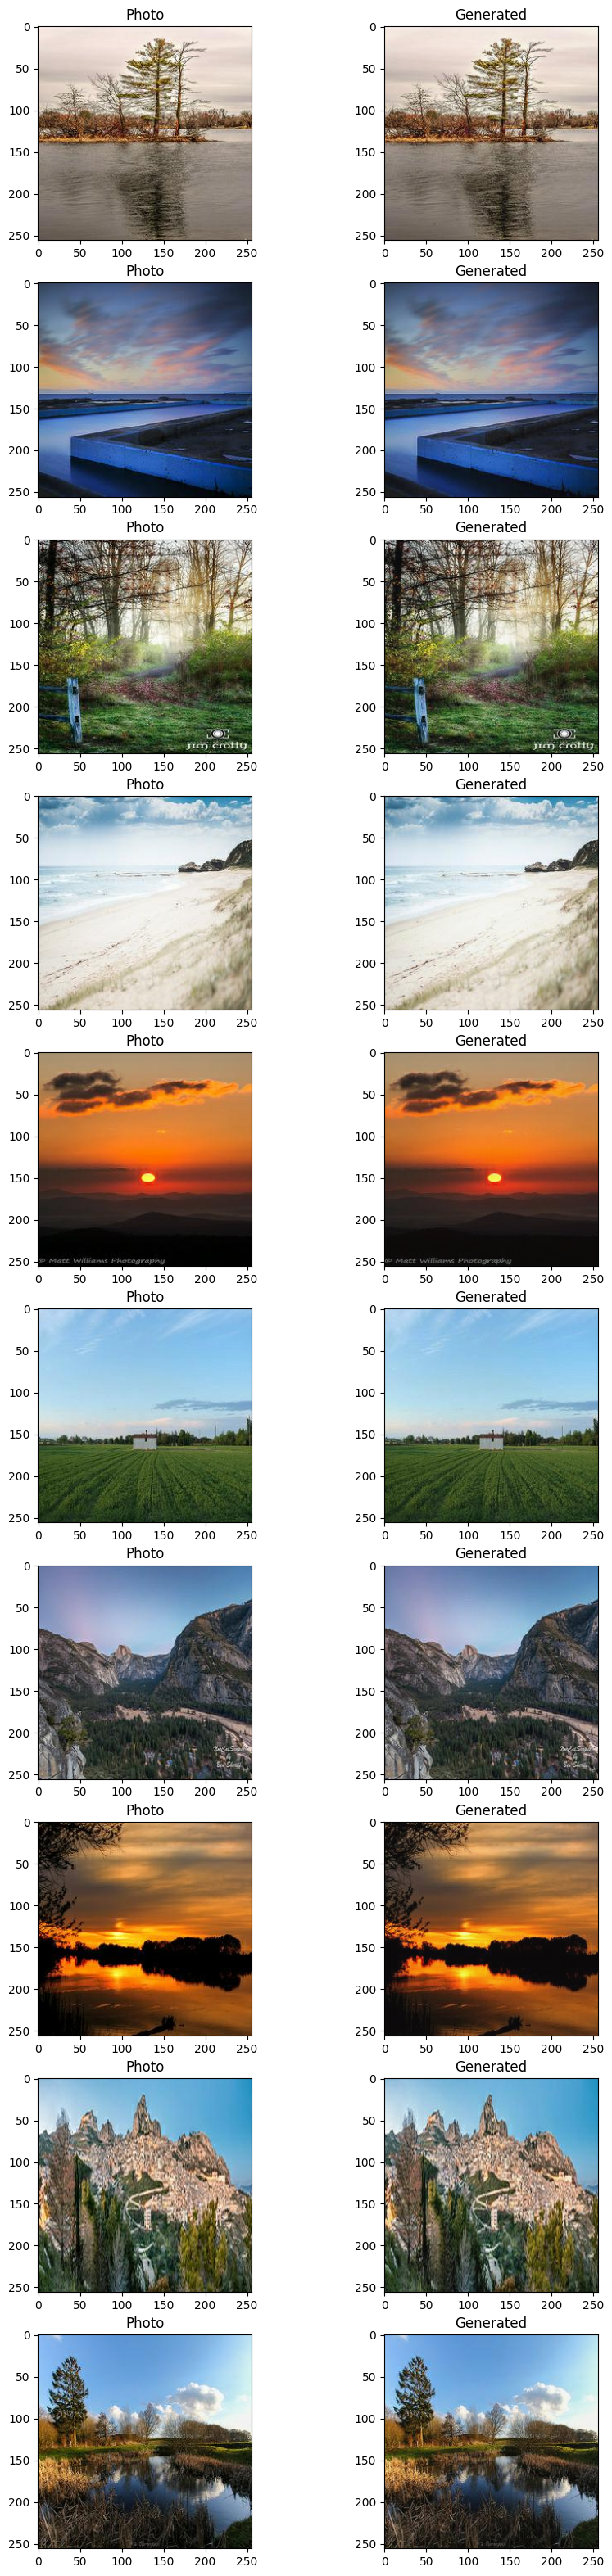

In [47]:
fig, ax = plt.subplots(10, 2, figsize=(10, 40))
for i, photo in enumerate(photo_ds.take(10)):
    ax[i,0].set_title("Photo")
    ax[i,0].imshow((photo[0]+1)/2)
    if i==3:
        print((monet_generator.predict(photo)[0]+1)/2)
    ax[i,1].set_title("Generated")
    ax[i,1].imshow((monet_generator.predict(photo)[0]+1)/2) #maybe add numpy #gan.m_gen(photo, training=False
plt.show()

# Submission #

1. Figure out why the value is not between 0 and 1

In [31]:
# for i, photo in enumerate(photo_ds.skip(6881)):
#     generated = (monet_generator(photo, training=False)[0]+1)/2
#     plt.imshow(generated)
#     plt.savefig("./images/"+str(i+6881)+".jpg")

In [32]:
# import shutil
# shutil.make_archive("images", 'zip', "./images")

# Performance #

Next steps:
1. Finding the appropriate architecture for generator and discriminator 
2. Data Augmentation for Monet Images
3. Look at other people code

In [36]:
pd.set_option('display.max_colwidth', 0)
performance_df = pd.DataFrame({"Change Log": ["original", "original", "original", "dropout for upsampling in generator 0.5", "random crop * 4 to 224*224*3 images, vgg-inspired architecture for generator", "vgg-inspired architecture for generator", "vgg-inspired architecture for generator, larger learning rate for generators 2e-3",
                                              "vgg-inspired architecture for generator, horizontal augmentations for monet images", "model architecture with increasing depth",  "model architecture with increasing depth", "model architecture with increasing depth, random crop to 128*128 and resize augmentation", 
                                              "model architecture with increasing depth, random crop and resize augmentation, kernel size 7 for first and last layer of generator", "model architecture with increasing depth, random crop to 224*224 and resize augmentation", "model architecture with increasing depth, 1367 additional data, random rotation, random flip and random crop to 224*224 and resize augmentation"], "Epochs":[10, 25, 100, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 25], 
                               "Monet Generator Loss":[2.0564, 1.5475, 1.1673, 2.0624, 3.1842, 4.6802, 4.2423, 4.5196, 1.6060, 1.2747, 1.5578, 1.7918, 1.5196, 1.0428], "Photo Generator Loss":[2.0042, 1.4709, 1.0788, 2.0119, 3.1645, 4.7839, 4.2708, 4.6523, 1.5532, 1.1908, 1.4909, 1.7332, 1.4950, 0.9487], 
                               "Monet Discriminator Loss":[0.1305, 0.1033, 1.5585e-04, 0.1201, 0.0337, 0.0673, 0.1183, 0.0903, 0.1075, 0.2717, 0.0571, 0.0420, 0.0012, 0.0226], "Photo Discriminator Loss":[0.0713, 0.1252, 5.5830e-04, 0.1023, 0.0282, 0.0240, 0.1038, 0.0909, 0.0374, 0.0033, 0.0451, 0.0520, 0.0020, 0.0105],
                               "MiFID":["NA", "NA", "NA", "NA", "NA", "177.11278", "NA", "NA", "NA", "NA", "NA", "NA", "NA", "NA"], 
                               "Visual Notes":["similar to original image", "similar to original image", "similar to original image", "NA", "more dissimilar to original image", 
                                        "artificial light source", "change of coloration in image", "change in color and artificial spots", "similar to original image", "similar to original image", "similar to original image", "similar to original image", "similar to original image", "similar to original image"]})
performance_df

,Change Log,Epochs,Monet Generator Loss,Photo Generator Loss,Monet Discriminator Loss,Photo Discriminator Loss,MiFID,Visual Notes
0,original,10,2.0564,2.0042,0.130500,0.071300,NA,similar to original image
1,original,25,1.5475,1.4709,0.103300,0.125200,NA,similar to original image
2,original,100,1.1673,1.0788,0.000156,0.000558,NA,similar to original image
3,dropout for upsampling in generator 0.5,10,2.0624,2.0119,0.120100,0.102300,NA,NA
4,"random crop * 4 to 224*224*3 images, vgg-inspired architecture for generator",10,3.1842,3.1645,0.033700,0.028200,NA,more dissimilar to original image
5,vgg-inspired architecture for generator,10,4.6802,4.7839,0.067300,0.024000,177.11278,artificial light source
6,"vgg-inspired architecture for generator, larger learning rate for generators 2e-3",10,4.2423,4.2708,0.118300,0.103800,NA,change of coloration in image
7,"vgg-inspired architecture for generator, horizontal augmentations for monet images",10,4.5196,4.6523,0.090300,0.090900,NA,change in color and artificial spots
8,model architecture with increasing depth,10,1.6060,1.5532,0.107500,0.037400,NA,similar to original image
9,model architecture with increasing depth,25,1.2747,1.1908,0.271700,0.003300,NA,similar to original image
